# Import Necessary Headers

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from itertools import product
from joblib import Parallel, delayed
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load Updated CSV into Pandas Dataframe

In [2]:
df = pd.read_csv("hong_et_al/df_updt.csv")

In [3]:
# Initial view of the frame
df.head(3)

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,cc_withdrawal-alcohol,cc_woundcheck,cc_woundinfection,cc_woundre-evaluation,cc_wristinjury,cc_wristpain
0,B,4.0,40.0,Male,Hispanic or Latino,White or Caucasian,English,NaN,Single,Full Time,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,B,4.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B,2.0,66.0,Male,Hispanic or Latino,Native Hawaiian or Other Pacific Islander,English,Pentecostal,Married,Not Employed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocess Data

In [4]:
# Drop CKD information columns
df = df.drop(columns=df.filter(like='chrkidneydisease').columns)

# Exclude columns describing direct parameter to CKD-EPI Creatinine Equation used to calculate eGFR
df = df.drop(columns=df.filter(like='creat').columns)

# Drop rows with NaN eGFR values
df.dropna(subset=['egfr_CKD_EPI'])

# Impute median data for any remaining NaN values in numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Cast categorical columns as type category
categorical_cols = ['dep_name', 'gender', 'ethnicity', 'race', 'lang', 'religion',
                    'maritalstatus', 'employstatus', 'insurance_status', 'disposition', 'arrivalmode',
                    'arrivalmonth', 'arrivalday', 'arrivalhour_bin', 'previousdispo']

df[categorical_cols] = df[categorical_cols].astype('category')

# Define Train and Test Data Sets

In [5]:
# Exclude target variable from features frame
X = df.drop(columns=df.filter(like='egfr').columns)

# Set target variable to egfr_CKD_EPI; calculated patient eGFR 
y = df['egfr_CKD_EPI']

def create_splits(X, y, test_size=0.1, val_size=0.2, n_splits=5, seed=42):
    np.random.seed(seed)  # Ensure reproducibility
    
    # Step 1: Split data into test and the remaining data
    X_traindev, X_test, y_traindev, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    # Step 2: Further split the remaining data into multiple train and validation sets
    val_sets = []
    for _ in range(n_splits):
        # Randomly select validation set from the remaining data
        X_train, X_val, y_train, y_val = train_test_split(X_traindev, y_traindev, test_size=val_size, random_state=np.random.randint(10000))
        
        val_sets.append({
            'X_train': X_train, 
            'y_train': y_train, 
            'X_val': X_val, 
            'y_val': y_val
        })

    return X_traindev, y_traindev, X_test, y_test, val_sets

X_traindev, y_traindev, X_test, y_test, val_sets = create_splits(X, y)

# Initialize XGBoost Regressor Model

In [6]:
# Initialize your model
model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=0, enable_categorical=True)

# GridSearch Hyperparameter Optimization

# Bayesian Hyperparameter Optimization

In [7]:
def evaluate_on_val_sets(model, params, val_sets):
    mse_scores = []
    for val in val_sets:
        # Set parameters and reinitialize the model to avoid leakage from previous fits
        model.set_params(**params)
        model.fit(val['X_train'], val['y_train'])

        try:
            # Predict on the validation set and calculate MSE
            preds = model.predict(val['X_val'])
            mse = mean_squared_error(val['y_val'], preds)
        except Exception as e:
            print(f"Error during model prediction: {str(e)}")
            mse = float('inf')  # Consider the worst case if prediction fails

        mse_scores.append(mse)
    
    # Calculate average MSE across all validation sets
    return np.mean(mse_scores)

In [8]:
# Define the search space
space = [
    Integer(5, 20, name='max_depth'),
    Integer(1, 10, name='min_child_weight'),
    Real(0.5, 5.0, name='gamma'),
    Real(0.6, 1.0, name='subsample'),
    Real(0.6, 1.0, name='colsample_bytree'),
    Real(0.01, 0.6, name='colsample_bylevel'),
    Real(0.01, 0.3, name='learning_rate'),
    Integer(50, 300, name='n_estimators')
]

# Define objective function
@use_named_args(space)
def objective(**params):
    print("Testing params:", params)  # Debug: print parameters to console
    mse = evaluate_on_val_sets(model, params, val_sets)
    print("MSE for params:", mse)  # Debug: print result to console
    return mse

# Perform Bayesian Optimization
result = gp_minimize(objective, space, n_calls=20, random_state=42)


# Extract the best parameters and the corresponding score
best_params = {dimension.name: result.x[i] for i, dimension in enumerate(space)}
best_score = result.fun

print("Best parameters found: ", best_params)
print("Best average MSE across validation sets: ", best_score)

Testing params: {'max_depth': 17, 'min_child_weight': 3, 'gamma': 4.008609501227463, 'subsample': 0.8387400631785948, 'colsample_bytree': 0.7783331011414365, 'colsample_bylevel': 0.06898520033262172, 'learning_rate': 0.1431821786701015, 'n_estimators': 133}
MSE for params: 71.39465390842571
Testing params: {'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.7538521056219512, 'subsample': 0.88879950890673, 'colsample_bytree': 0.9754210836063002, 'colsample_bylevel': 0.010459471846198455, 'learning_rate': 0.29774135219445313, 'n_estimators': 204}
MSE for params: 99.85555021444854
Testing params: {'max_depth': 14, 'min_child_weight': 1, 'gamma': 0.6037809126863709, 'subsample': 0.8099098641033557, 'colsample_bytree': 0.7599443886861023, 'colsample_bylevel': 0.0375327412960331, 'learning_rate': 0.2923891004640232, 'n_estimators': 108}
MSE for params: 83.26898841879735
Testing params: {'max_depth': 6, 'min_child_weight': 7, 'gamma': 2.2210789607022328, 'subsample': 0.9932923543227153, 'colsa

# Train XG Boost Regressor on Full Training Set

In [9]:
# Train the XG Boost regressor model on the full training set with tuned hyperparameters
model.set_params(**best_params)
model.fit(X_traindev, y_traindev)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.3380811742487824, colsample_bynode=None,
             colsample_bytree=0.8402697018658802, device=None,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, feature_types=None, gamma=3.7707918147903334,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07999670229582109,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluate Accuracy on Test Set

In [11]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

Mean Squared Error: 61.09008481398016
Root Mean Squared Error: 7.816014637523407
R² Score: 0.8488968709910368


C:\Users\zdana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Evaluate Feature Importance

In [17]:
# Retrieve feature importances
importances = model.feature_importances_

# Create a frame for feature importance visualization
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance frame
print(feature_importance.head(30))

                           Feature  Importance
561                     bun_median    0.057047
479                        bun_max    0.050016
397                        bun_min    0.048863
315                       bun_last    0.031983
606                  pocbun_median    0.026832
913              cc_sicklecellpain    0.023514
138                            htn    0.020952
442                     pocbun_min    0.014346
9                     employstatus    0.011165
2                              age    0.010245
540             troponini(poc)_max    0.010087
524                     pocbun_max    0.009046
541                  troponint_max    0.008456
249                    poisonpsych    0.007307
5                             race    0.007284
459                  troponint_min    0.005574
724  meds_colonystimulatingfactors    0.005485
622          troponini(poc)_median    0.005433
623               troponint_median    0.005376
196                     otdxkidney    0.005139
650          

# Visualize Feature Importance

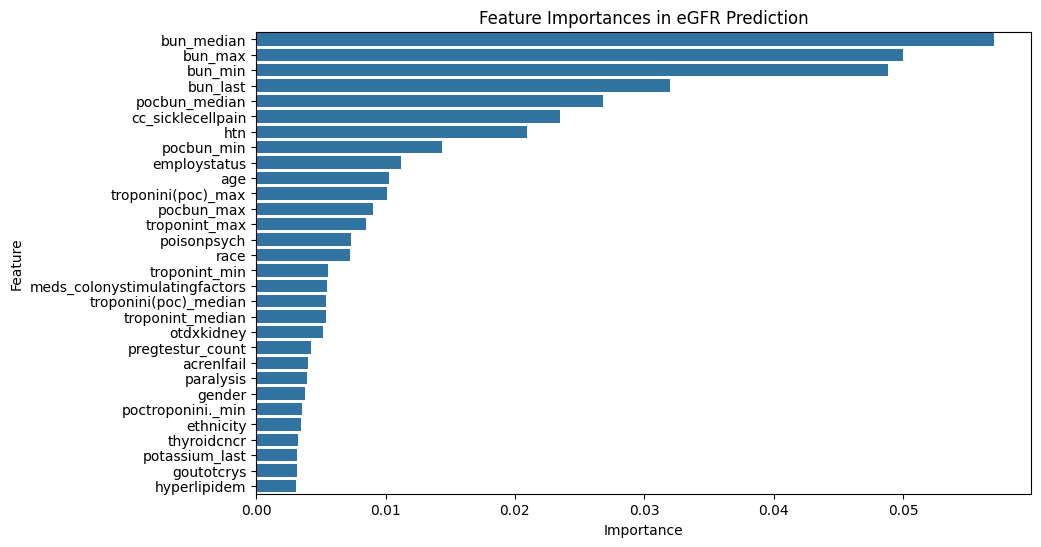

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(30))
plt.title('Feature Importances in eGFR Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()